In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Internal clustering evaluation metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
# External clustering evaluation metrics
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, v_measure_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
import time
from typing import Tuple
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
'''
1. Examine and Handle missing values (e.g., fill the missing value, add a corresponding label).
2. Handle non-numeric values (e.g. one-hot encoding, Boolean indicator).
3. Further processing (e.g. standardize features).
'''

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

def handle_missing_values():
    pass

def csv_convert(input_path, output_path):
    """
    Convert the data file to CSV format
    """
    try:
        # Read the data file
        df = pd.read_csv(input_path, header=None, names=columns, skipinitialspace=True)
        # Save as CSV
        df.to_csv(output_path, index=False)
        print(f"Successfully converted {input_path} to {output_path}")
    except Exception as e:
        print(f"Conversion failure: {e}")

def missing_value_processing(input_path, output_path):
    """
    Handle missing values
    """
    # The first row needs to be avoided because it is a column name
    try:
        # Read the data file
        df = pd.read_csv(input_path, header=None, names=columns, skipinitialspace=True, skiprows=1)
        # Replace the missing value with NaN
        df.replace('?', pd.NA, inplace=True)
        
        # For numerical variables, use the mean to fill in the missing values
        numerical_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
        for col in numerical_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            mean_value = df[col].mean()
            df[col] = df[col].fillna(mean_value)

        # For categorical variables, use the mode to fill in the missing values
        categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
        for col in categorical_columns:
            mode_value = df[col].mode()[0]
            #print(f"Mode value for {col}: {mode_value}")
            df[col] = df[col].fillna(mode_value)
        
        # Save the processed data
        df.to_csv(output_path, index=False)
        print(f"Successfully processed the missing values of {input_path} and saved them as {output_path}")

    except Exception as e:
        print(f"处理{input_path}缺失值失败: {e}")

def data_type_conversion(input_path, output_path):
    """
    Convert the data types of the columns in the dataset
    """
    try:
        # Read the data file
        df = pd.read_csv(input_path, header=None, names=columns, skipinitialspace=True, skiprows=1)
        
        # Type conversion
        categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
        for col in categorical_columns:
            # 1. if the column has only two unique values, use bool encoding
            if df[col].nunique() == 2:
                df[col] = df[col].map({df[col].unique()[0]: 0, df[col].unique()[1]: 1})
            # 2. Otherwise，one_hot encoding
            else:
                dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
                # Perform 0-1 encoding instead of True-False encoding
                dummies = dummies.astype(int)
                df = pd.concat([df, dummies], axis=1)
                df.drop(col, axis=1, inplace=True)
        
        # Standardize the numerical variables
        numerical_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
        for col in numerical_columns:
            df[col] = (df[col] - df[col].mean()) / df[col].std()
        
        # Save the processed data
        df.to_csv(output_path, index=False)
        print(f"Successfully converted the data type {input_path} and saved it as {output_path}")
    except Exception as e:
        print(f"Data type conversion failed: {e}")    

In [3]:
if __name__ == "__main__":
    # Load the dataset
    train_data_path = './raw/adult.data'
    test_data_path = './raw/adult.test'

    # If the dataset exists, output prompt information
    if os.path.exists(train_data_path) and os.path.exists(test_data_path):
        print("The dataset path already exists. Start processing the dataset...")
    else:
        print("The dataset path does not exist. Please check the path.")
        exit()

    # Read the dataset and convert it to csv format
    train_csv_path = './data/adult_train.csv'
    test_csv_path = './data/adult_test.csv'
    csv_convert(train_data_path, train_csv_path)
    csv_convert(test_data_path, test_csv_path)

    # 1. For the training set and test set, handle the missing values first
    # The missing value here is indicated as "?" ; For numerical variables, use mean filling; For categorical variables, mode filling is used
    filled_train_csv_path = './data/adult_train_filled.csv'
    filled_test_csv_path = './data/adult_test_filled.csv'
    missing_value_processing(train_csv_path, filled_train_csv_path)
    missing_value_processing(test_csv_path, filled_test_csv_path)

    # 2. For the training set and the test set, perform data preprocessing
    # 2.1 For binary class variables, perform boolean encoding; For multivariate class variables, one-hot encoding is performed
    # 2.2 For numerical variables, carry out standardization processing
    processed_train_csv_path = './data/adult_train_processed.csv'
    processed_test_csv_path = './data/adult_test_processed.csv'
    data_type_conversion(filled_train_csv_path, processed_train_csv_path)
    data_type_conversion(filled_test_csv_path, processed_test_csv_path)

The dataset path already exists. Start processing the dataset...
Successfully converted ./raw/adult.data to ./data/adult_train.csv
Successfully converted ./raw/adult.test to ./data/adult_test.csv
Successfully processed the missing values of ./data/adult_train.csv and saved them as ./data/adult_train_filled.csv
Successfully processed the missing values of ./data/adult_test.csv and saved them as ./data/adult_test_filled.csv
Successfully converted the data type ./data/adult_train_filled.csv and saved it as ./data/adult_train_processed.csv
Successfully converted the data type ./data/adult_test_filled.csv and saved it as ./data/adult_test_processed.csv


In [4]:
'''
# t-SNE Visualization
1.Visualize high-dimensional data in a 2D and/or 3D space using t-SNE
2. Create a scatter plot of the resulting embedding, coloring points by class labels if applicable.
3. Analyze the visualization to identify patterns or clusters.
'''



def visualize_tsne_2d(data, labels=None, title='t-SNE Visualization (2D)', 
                     save_path=None, colormap='tab20', balance_classes=False,
                     point_size=30, alpha=0.5, legend_loc='best'):
    """
    Visualize high-dimensional data in 2D using t-SNE.

    """
    # Balence_classes: whether to balance the number of samples in each class
    if balance_classes and labels is not None:
        data, labels = _balance_classes(data, labels)

    # t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1200)
    embedded_data = tsne.fit_transform(data)
    
    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    
    if labels is not None:
        # Arrange in reverse order by category sample size (draw the majority class first)
        unique_labels, counts = np.unique(labels, return_counts=True)
        sorted_labels = unique_labels[np.argsort(-counts)]
        
        # Create discrete color mappings
        cmap = plt.get_cmap('Set1')  
        colors = cmap(np.linspace(0, 1, len(unique_labels)))

        # Draw each category layer by layer
        for idx, label in enumerate(sorted_labels):
            mask = labels == label
            plt.scatter(embedded_data[mask, 0], embedded_data[mask, 1],
                        c=[colors[idx]], label=str(label),
                        s=point_size, alpha=alpha, edgecolors='w', linewidth=0.3)
            
        # Add legend
        plt.legend(title='Class Labels', loc=legend_loc,
                  frameon=True, framealpha=0.8)
    else:
        plt.scatter(embedded_data[:, 0], embedded_data[:, 1],
                   s=point_size, alpha=alpha, edgecolors='w', linewidth=0.3)
    
    # Add labels and grids
    plt.title(title, pad=20)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.grid(alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300, facecolor='white')
    
    plt.show()
    return embedded_data

def _balance_classes(data, labels):
    """The category balancing function used internally"""
    unique_labels, counts = np.unique(labels, return_counts=True)
    min_count = np.min(counts)
    
    sampled_indices = []
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        if len(indices) > min_count:
            indices = np.random.choice(indices, min_count, replace=False)
        sampled_indices.append(indices)
    
    sampled_indices = np.concatenate(sampled_indices)
    return data[sampled_indices], labels[sampled_indices]


def visualize_tsne_3d(data, labels=None, title='t-SNE Visualization (3D)', save_path=None, colormap='viridis', balance_classes=False):
    """
    Visualize high-dimensional data in 3D using t-SNE.
    
    Parameters:
    -----------
    data : array-like
        High-dimensional data to visualize.
    labels : array-like, optional
        Class labels for each data point.
    title : str, optional
        Title for the plot.
    save_path : str, optional
        Path to save the visualization.
    colormap : str, optional
        Colormap to use for the scatter plot.
    """
    if balance_classes and labels is not None:
        data, labels = _balance_classes(data, labels)
    
    # Apply t-SNE for dimensionality reduction to 3D
    tsne = TSNE(n_components=3, random_state=42, perplexity=30, max_iter=1200)
    embedded_data = tsne.fit_transform(data)
    
    # Create a 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        # If labels are provided, color points by labels
        scatter = ax.scatter(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2], 
                  c=labels, cmap='Set1', alpha=0.5, s=10)
        plt.colorbar(scatter, label='Class Labels')
    else:
        # If no labels, use a single color
        ax.scatter(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2], 
                   alpha=0.8, s=50)
    
    ax.set_title(title)
    ax.set_xlabel('t-SNE Feature 1')
    ax.set_ylabel('t-SNE Feature 2')
    ax.set_zlabel('t-SNE Feature 3')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()
    
    return embedded_data

def analyze_clusters(embedded_data, labels=None):
    """
    Analyze the t-SNE embedding to identify patterns or clusters.
    
    Parameters:
    -----------
    embedded_data : array-like
        Low-dimensional embedding from t-SNE.
    labels : array-like, optional
        Class labels for each data point.
    """
    if labels is None:
        print("No labels provided for cluster analysis.")
        return
    
    # Calculate cluster statistics
    unique_labels = np.unique(labels)
    print(f"Number of clusters/classes: {len(unique_labels)}")
    
    # Compute basic statistics for each cluster
    for label in unique_labels:
        cluster_points = embedded_data[labels == label]
        center = np.mean(cluster_points, axis=0)
        std_dev = np.std(cluster_points, axis=0)
        count = len(cluster_points)
        
        print(f"\nCluster/Class {label}:")
        print(f"  Number of points: {count}")
        print(f"  Center: {center}")
        print(f"  Standard deviation: {std_dev}")
        
    # Visual analysis with a pairplot if using 3D embedding
    if embedded_data.shape[1] >= 2:
        df = pd.DataFrame(embedded_data[:, :3], columns=[f'Component {i+1}' for i in range(min(3, embedded_data.shape[1]))])
        if labels is not None:
            df['Label'] = labels
            sns.pairplot(df, hue='Label')
            plt.suptitle('Pairwise Relationships Between t-SNE Components', y=1.02)
            plt.show()



Loaded training data shape: (32561, 98)
Loaded test data shape: (16281, 97)

--- Training Data Visualization ---
Visualizing training data in 2D...


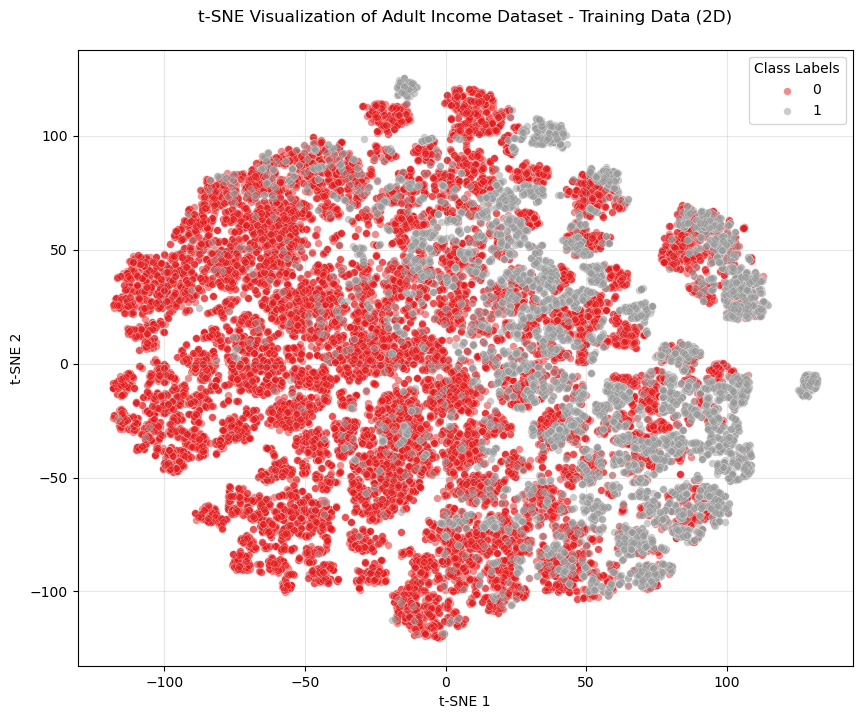


Visualizing training data in 3D...


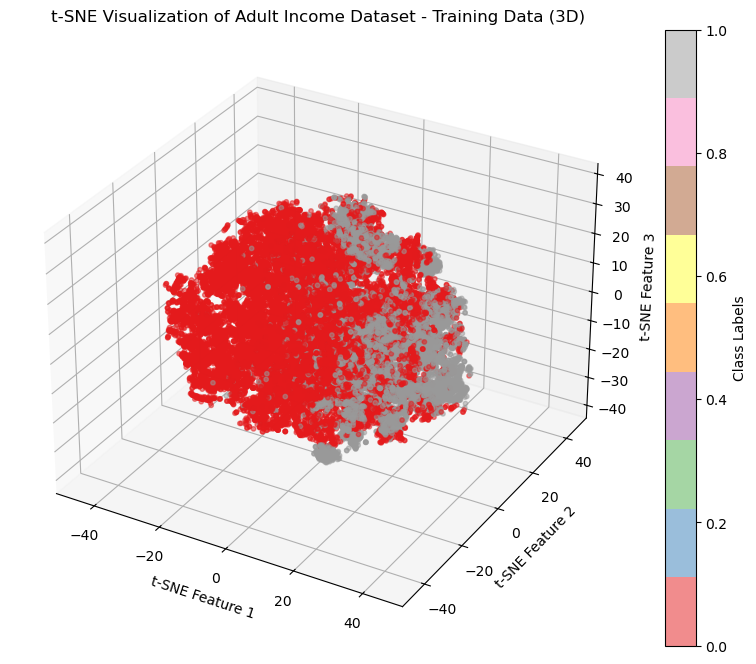


--- Analyzing Clusters in Training Data ---
Number of clusters/classes: 2

Cluster/Class 0:
  Number of points: 24720
  Center: [-17.371532    -0.36554274]
  Standard deviation: [51.908134 57.609432]

Cluster/Class 1:
  Number of points: 7841
  Center: [54.20705    2.6225066]
  Standard deviation: [40.777863 54.520287]


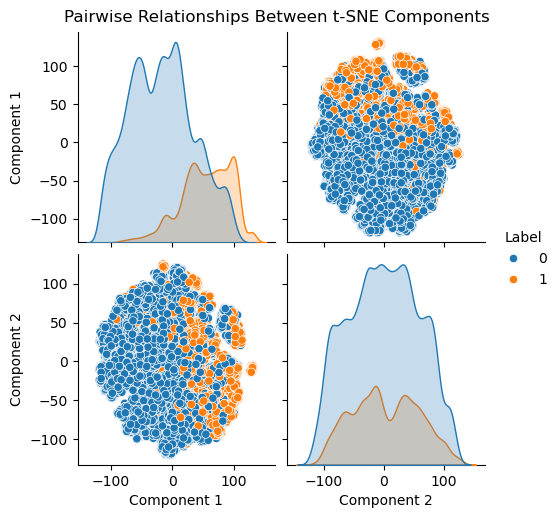

Number of clusters/classes: 2

Cluster/Class 0:
  Number of points: 24720
  Center: [-5.6512566  -0.45417693  0.32997888]
  Standard deviation: [16.498224 18.58957  14.85698 ]

Cluster/Class 1:
  Number of points: 7841
  Center: [16.881708   1.7484149 -1.3243947]
  Standard deviation: [13.409846 15.474093 17.142935]


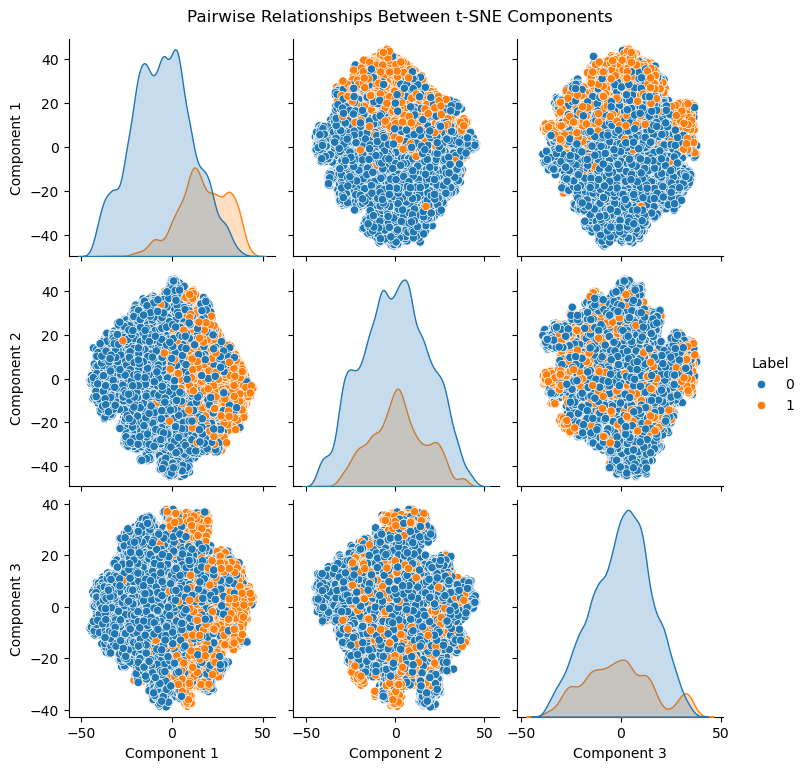

In [5]:
if __name__ == "__main__":
    # Load data from the specified CSV files
    train_data = pd.read_csv('./data/adult_train_processed.csv')
    test_data = pd.read_csv('./data/adult_test_processed.csv')
    
    print(f"Loaded training data shape: {train_data.shape}")
    print(f"Loaded test data shape: {test_data.shape}")
    
    # Assuming the last column is the target/label
    X_train = train_data.iloc[:, :-7].values
    y_train = train_data.iloc[:, 7].values
    
    X_test = test_data.iloc[:, :7].values
    y_test = test_data.iloc[:, 7].values
    
    
    print("\n--- Training Data Visualization ---")
    print("Visualizing training data in 2D...")
    embedded_train_2d = visualize_tsne_2d(
        X_train, 
        y_train, 
        title='t-SNE Visualization of Adult Income Dataset - Training Data (2D)',
        save_path='./figures/tsne_train_2d.png',
        colormap='tab10'  # Using a discrete colormap better for categorical data
    )
    
    
    print("\nVisualizing training data in 3D...")
    embedded_train_3d = visualize_tsne_3d(
        X_train, 
        y_train, 
        title='t-SNE Visualization of Adult Income Dataset - Training Data (3D)',
        save_path='./figures/tsne_train_3d.png',
        colormap='tab10'  # Using a discrete colormap better for categorical data
    )
    print("\n--- Analyzing Clusters in Training Data ---")
    analyze_clusters(embedded_train_2d, y_train)
    analyze_clusters(embedded_train_3d, y_train)

Dimension reduction is carried out using PCA
PCA dimension reduction completed
Cumulative variance contribution rate: 0.9902
Use LDA for dimensionality reduction
The dimension reduction of LDA has been completed
PCA+LDA Dimension reduction completed
Visualize the clustering results of K-means ++...
Visualize the clustering results of the K-Means++(Raw)...


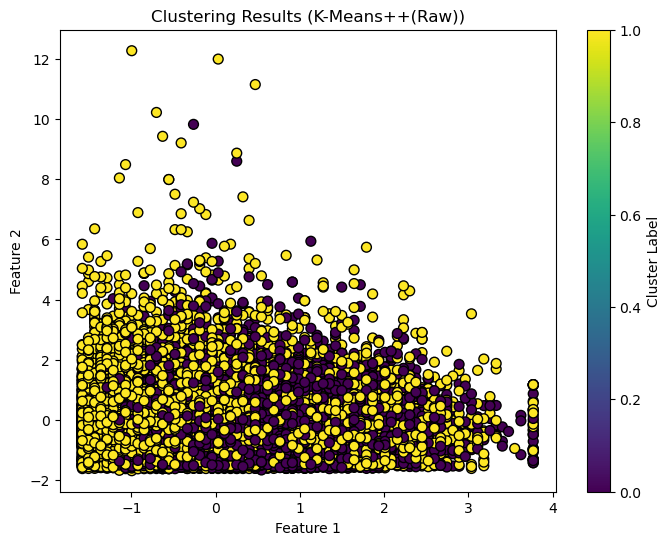

The visualization results have been saved to./figures/K-Means++(Raw).png
Visualize the clustering results of the K-Means++(PCA)...


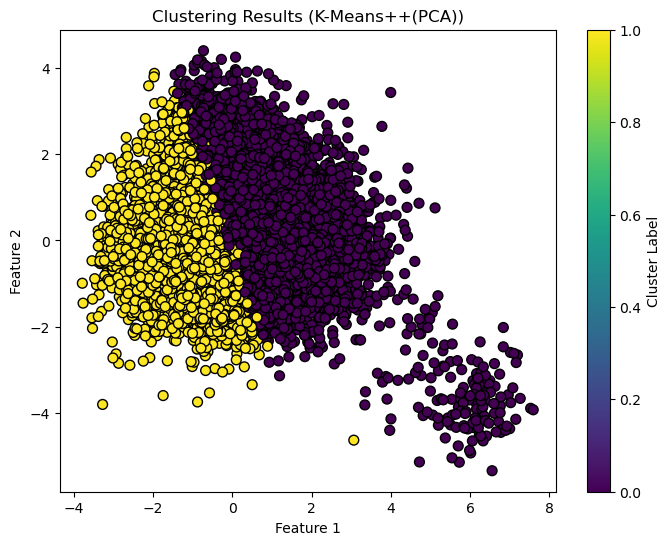

The visualization results have been saved to./figures/K-Means++(PCA).png
Visualize the clustering results of the K-Means++(LDA)...


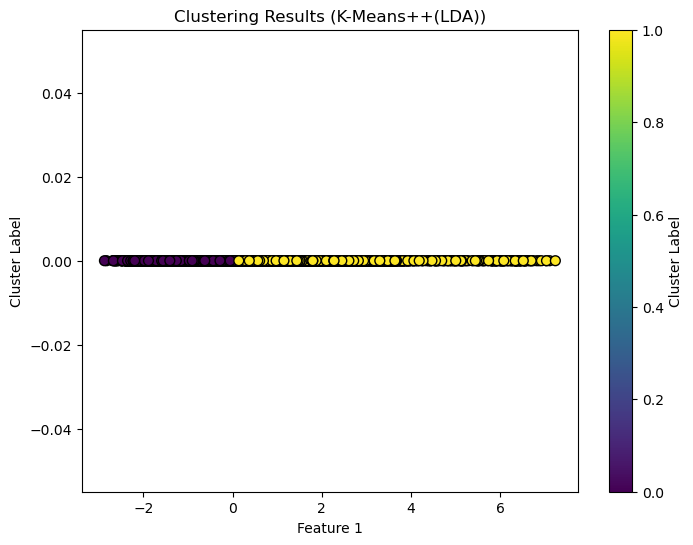

The visualization results have been saved to./figures/K-Means++(LDA).png
Visualize the clustering results of the K-Means++(PCA+LDA)...


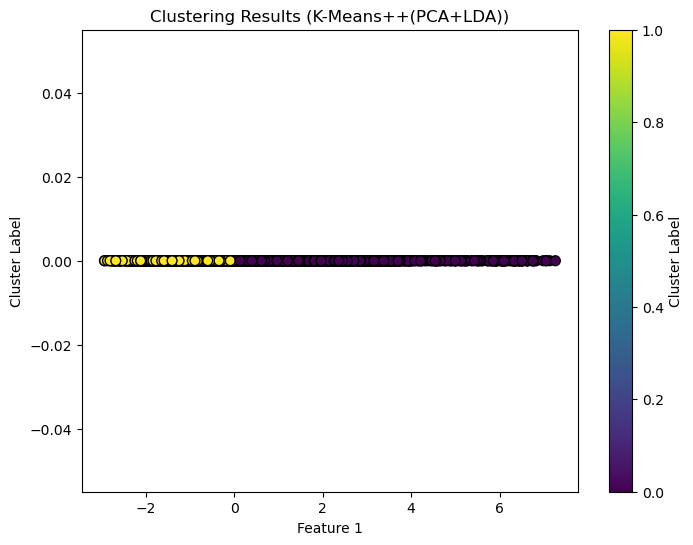

The visualization results have been saved to./figures/K-Means++(PCA+LDA).png
Visualize the DBSCAN clustering results...
Visualize the clustering results of the DBSCAN(Raw)...


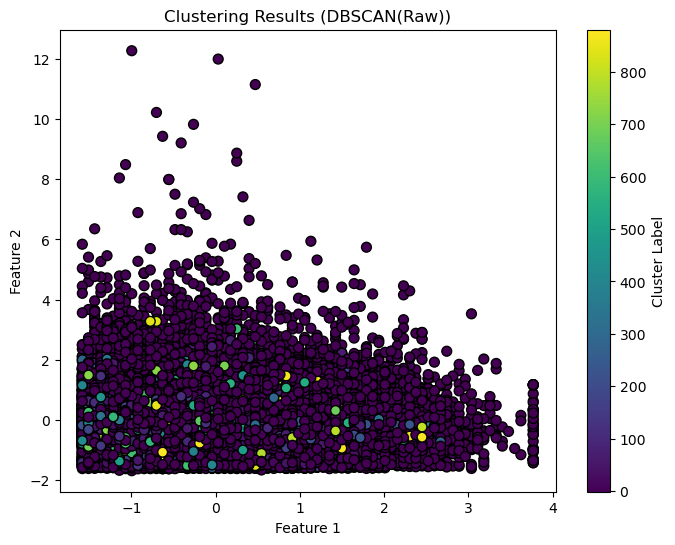

The visualization results have been saved to./figures/DBSCAN(Raw).png
Visualize the clustering results of the DBSCAN(PCA)...


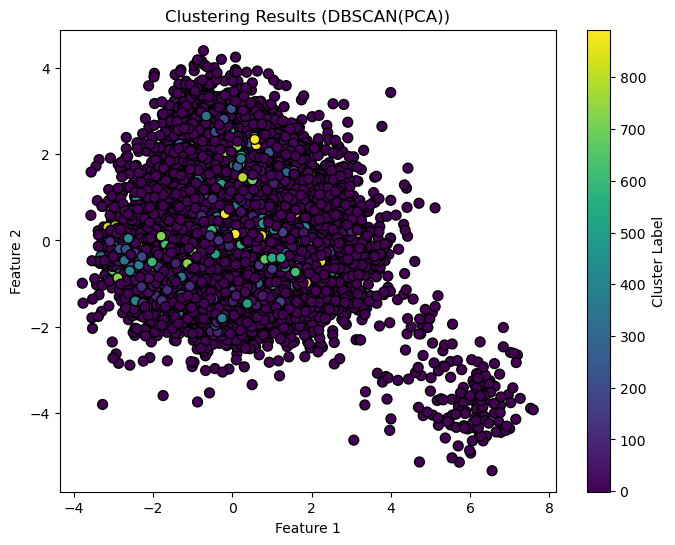

The visualization results have been saved to./figures/DBSCAN(PCA).png
Visualize the clustering results of the DBSCAN(LDA)...


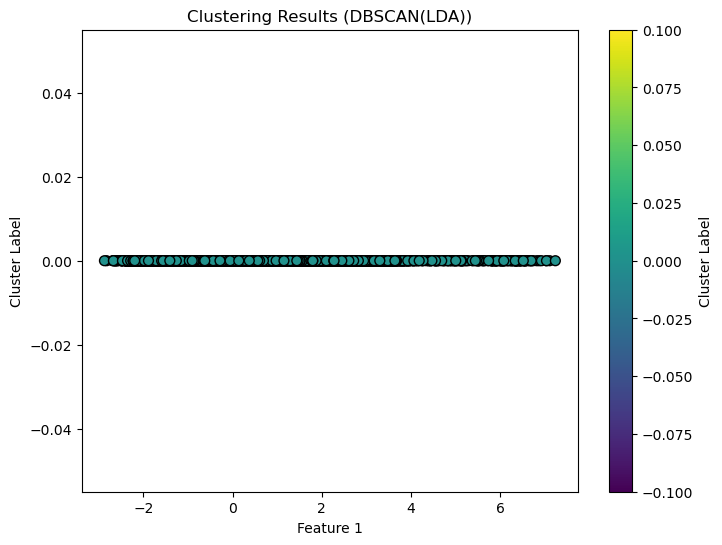

The visualization results have been saved to./figures/DBSCAN(LDA).png
Visualize the clustering results of the DBSCAN(PCA+LDA)...


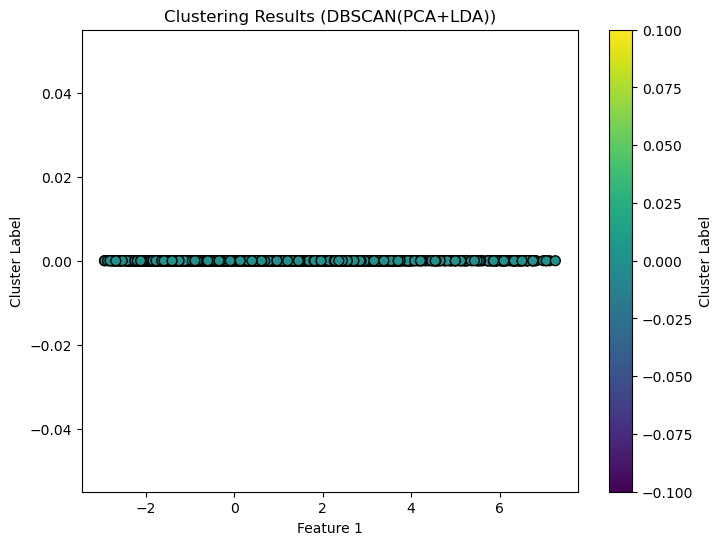

The visualization results have been saved to./figures/DBSCAN(PCA+LDA).png
Visualize the hierarchical clustering results...
Visualize the clustering results of the AgglomerativeClustering(Raw)...


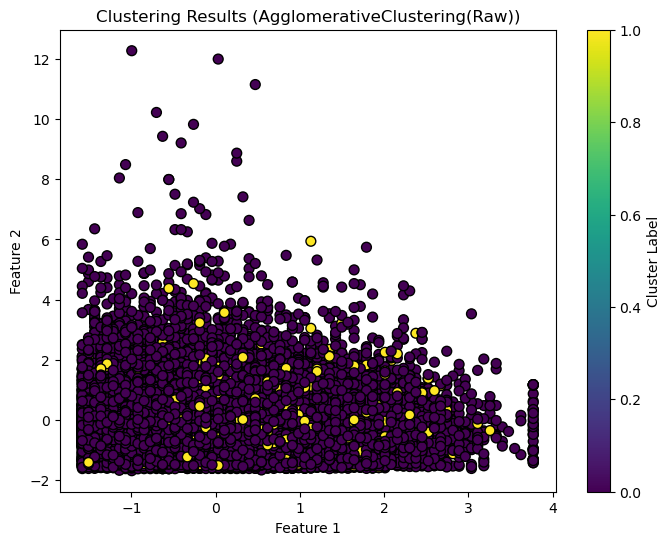

The visualization results have been saved to./figures/AgglomerativeClustering(Raw).png
Visualize the clustering results of the AgglomerativeClustering(PCA)...


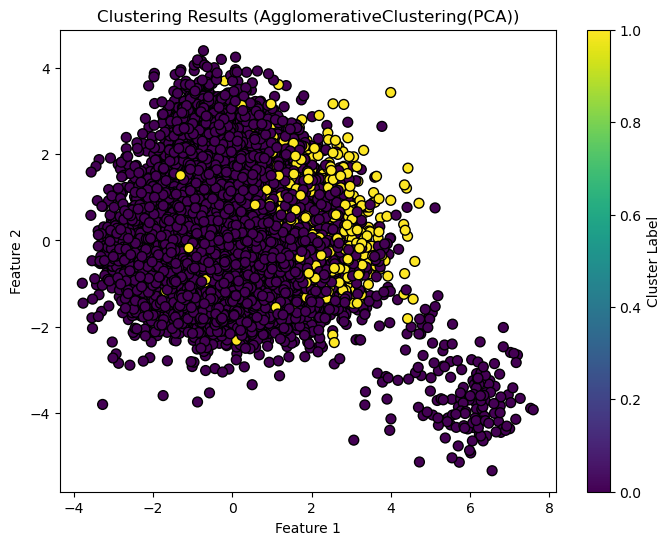

The visualization results have been saved to./figures/AgglomerativeClustering(PCA).png
Visualize the clustering results of the AgglomerativeClustering(LDA)...


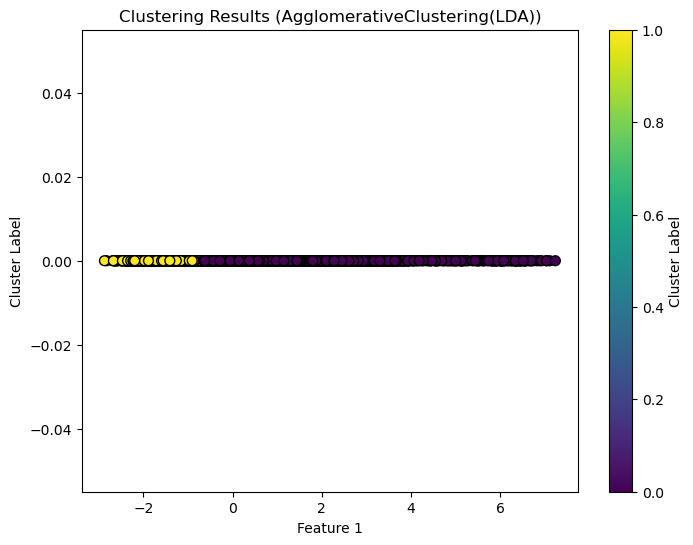

The visualization results have been saved to./figures/AgglomerativeClustering(LDA).png
Visualize the clustering results of the AgglomerativeClustering(PCA+LDA)...


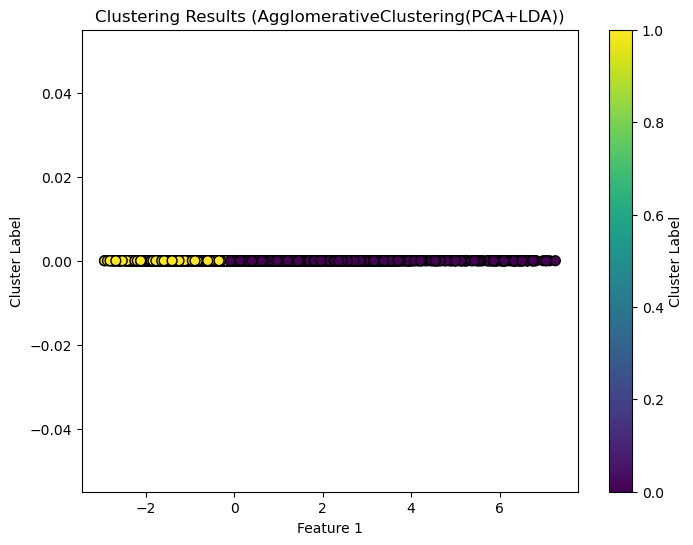

The visualization results have been saved to./figures/AgglomerativeClustering(PCA+LDA).png


In [6]:
'''
1. Select at least two suitable clustering algorithm (e.g., K-means, hierarchical clustering).
2. Apply the algorithms to the preprocessed dataset.
3. Evaluate the results using multiple metrics.
4. Visualize the clusters (e.g., scatter plot with cluster labels).
5. Determine the best clustering results and justify it.
'''



# 1.read the data
data = pd.read_csv('./data/adult_train_processed.csv')
# Label/response variable: Whether the annual income is greater than 50K
label = data['income']
# Data/input variables: Other characteristics
feature = data.drop(columns=['income'])

# 2. Dimensionality reduction
# 2.1Dimension reduction is carried out using PCA
print("Dimension reduction is carried out using PCA")
pca = PCA(n_components=0.99)
feature_pca = None
feature_pca = pca.fit_transform(feature)
if feature_pca is not None:
    print("PCA dimension reduction completed")
else:
    print("PCA dimension reduction failed")
    exit()
print(f"Cumulative variance contribution rate: {sum(pca.explained_variance_ratio_):.4f}")


# 2.3Use LDA for dimensionality reduction
print("Use LDA for dimensionality reduction")
# n_components cannot be larger than min(n_classes - 1, n_features)
# n_classes = 2, n_features = 2，n_components = 1
lda = LinearDiscriminantAnalysis(n_components=1)
feature_lda = None
feature_lda = lda.fit_transform(feature, label)
if feature_lda is not None:
    print("The dimension reduction of LDA has been completed")
else:
    print("The dimension reduction of LDA failed")
    exit()

# 2.4 First, use PCA for dimensionality reduction, and then use LDA for dimensionality reduction
feature_pca_lda = None
feature_pca_lda = lda.fit_transform(feature_pca, label)
if feature_pca_lda is not None:
    print("PCA+LDA Dimension reduction completed")
else:
    print("PCA+LDA Dimension reduction failure")
    exit()
# 3.Clustering algorithm
# 3.1 K-means ++ clustering

n_clusters = label.nunique()  # Two clusters
kmeans = KMeans(n_clusters, init='k-means++', random_state=42)
# Try different dimensionality reduction methods and conduct K-Means clustering with the original data
kmeans_labels_pca = kmeans.fit_predict(feature_pca)
#kmeans_labels_mds = kmeans.fit_predict(feature_mds)
kmeans_labels_lda = kmeans.fit_predict(feature_lda)
kmeans_labels_raw = kmeans.fit_predict(feature)
kmeans_labels_pca_lda = kmeans.fit_predict(feature_pca_lda)

# 3.2 DBSCAN clustering

dbscan = DBSCAN(eps=0.5, min_samples=3)
# Try different dimensionality reduction methods and conduct hierarchical clustering with the original data
dbscan_labels_pca = dbscan.fit_predict(feature_pca)
#dbscan_labels_mds = dbscan.fit_predict(feature_mds)
dbscan_labels_lda = dbscan.fit_predict(feature_lda)
dbscan_labels_raw = dbscan.fit_predict(feature)
dbscan_labels_pca_lda = dbscan.fit_predict(feature_pca_lda)

# In the DBSCAN clustering results, -1 represents the noise point
# 3.3 Hierarchical clustering

agglo = AgglomerativeClustering(n_clusters=n_clusters)
# Try different dimensionality reduction methods and conduct hierarchical clustering with the original data
agglo_labels_pca = agglo.fit_predict(feature_pca)
#agglo_labels_mds = agglo.fit_predict(feature_mds)
agglo_labels_lda = agglo.fit_predict(feature_lda)
agglo_labels_raw = agglo.fit_predict(feature)
agglo_labels_pca_lda = agglo.fit_predict(feature_pca_lda)

# 4.Evaluate the clustering results

# 4.1 Internal evaluation indicators
def evaluate_clustering_internal(data, labels):
    """
    Evaluate clustering results using internal metrics.
    
    Parameters:
    -----------
    data : array-like
        High-dimensional data used for clustering.
    labels : array-like
        Cluster labels assigned to each data point.
    
    Returns:
    --------
    dict : Dictionary containing evaluation metrics.
    """
    silhouette = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    
    return silhouette, calinski_harabasz, davies_bouldin

# 4.2 External evaluation indicators
def evaluate_clustering_external(true_labels, predicted_labels):
    """
    Evaluate clustering results using external metrics.
    
    Parameters:
    -----------
    true_labels : array-like
        True class labels for each data point.
    predicted_labels : array-like
        Cluster labels assigned to each data point.
    
    Returns:
    --------
    dict : Dictionary containing evaluation metrics.
    """
    ari = adjusted_rand_score(true_labels, predicted_labels)
    ami = adjusted_mutual_info_score(true_labels, predicted_labels)
    v_measure = v_measure_score(true_labels, predicted_labels)
    
    return ari, ami, v_measure

# 4.3 The evaluation of three clustering methods and different dimensionality reduction methods

def evaluate(external_metrics:tuple, internal_metrics:tuple, method:str):
    # print the evaluation results for the clustering methods
    ari, ami, v_measure = external_metrics
    silhouette, calinski_harabasz, davies_bouldin = internal_metrics
    print(f"clustering method: {method}")
    print(f"External evaluation indicators: ARI:{ari:.4f}(Range: [-1, 1]), AMI:{ami:.4f}(Range: [0, 1]), V-measure:{v_measure:.4f}(Range: [0, 1])")
    print(f"Internal evaluation indicators: Silhouette:{silhouette:.4f}(Range: [-1, 1]), Calinski-Harabasz:{calinski_harabasz:.4f}(Range: [0, +∞]), Davies-Bouldin:{davies_bouldin:.4f}(Range: [0, +∞])")
    print("-----------------------------------------------------")

# 4.3.1 K-means ++ clustering evaluation
k_means_results = {"Raw": kmeans_labels_raw, "PCA": kmeans_labels_pca, "LDA": kmeans_labels_lda, "PCA+LDA": kmeans_labels_pca_lda}
'''
for method, kmeans_labels in k_means_results.items():
    internal_metrics = evaluate_clustering_internal(feature, kmeans_labels)
    external_metrics = evaluate_clustering_external(label, kmeans_labels)
    evaluate(external_metrics, internal_metrics, f"K-Means++({method})")
'''


# 4.3.2 DBSCAN clustering evaluation
dbscan_results = {"Raw": dbscan_labels_raw, "PCA": dbscan_labels_pca, "LDA": dbscan_labels_lda, "PCA+LDA": dbscan_labels_pca_lda}
'''
for method, dbscan_labels in dbscan_results.items():
    if len(np.unique(dbscan_labels)) == 1:
        print(f"DBSCAN({method})The clustering result has only one cluster and cannot be evaluated")
        continue
    else:
        internal_metrics = evaluate_clustering_internal(feature, dbscan_labels)
    external_metrics = evaluate_clustering_external(label, dbscan_labels)
    evaluate(external_metrics, internal_metrics, f"DBSCAN({method})")
'''


# 4.3.3 Hierarchical clustering evaluation
agglo_results = {"Raw": agglo_labels_raw, "PCA": agglo_labels_pca, "LDA": agglo_labels_lda, "PCA+LDA": agglo_labels_pca_lda}
'''
for method, agglo_labels in agglo_results.items():
    internal_metrics = evaluate_clustering_internal(feature, agglo_labels)
    external_metrics = evaluate_clustering_external(label, agglo_labels)
    evaluate(external_metrics, internal_metrics, f"AgglomerativeClustering({method})")
'''



# 5.Visualize the clustering results


def visualize_2d(data, labels, method: str):
    """
    Visualize clustering results in 2D or 1D.
    
    Parameters:
    -----------
    data : array-like
        Data used for clustering.
    labels : array-like
        Cluster labels assigned to each data point.
    method : str
        Clustering method used.
    """
    print(f"Visualize the clustering results of the {method}...")
    plt.figure(figsize=(8, 6))
    if data.shape[1] == 1:  # If there is only one feature
        plt.scatter(data[:, 0], [0] * len(data), c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
        plt.xlabel("Feature 1")
        plt.ylabel("Cluster Label")
    else:  # Normal two-dimensional visualization
        plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
    plt.title(f"Clustering Results ({method})")
    plt.colorbar(label="Cluster Label")
    plt.show()
    # Save the visualization results to./figures/
    plt.savefig(f"./figures/{method}.png")
    plt.close()
    print(f"The visualization results have been saved to./figures/{method}.png")

# 5.1 Visualize the clustering results of K-means ++
print("Visualize the clustering results of K-means ++...")
# Raw data visualization
visualize_2d(feature.values, kmeans_labels_raw, "K-Means++(Raw)")
# PCA data visualization
visualize_2d(feature_pca, kmeans_labels_pca, "K-Means++(PCA)")
# LDA data visualization
visualize_2d(feature_lda, kmeans_labels_lda, "K-Means++(LDA)")
# PCA+LDA data visualization
visualize_2d(feature_pca_lda, kmeans_labels_pca_lda, "K-Means++(PCA+LDA)")


# 5.2 Visualize the DBSCAN clustering results
print("Visualize the DBSCAN clustering results...")
# Raw data visualization
visualize_2d(feature.values, dbscan_labels_raw, "DBSCAN(Raw)")
# PCA data visualization
visualize_2d(feature_pca, dbscan_labels_pca, "DBSCAN(PCA)")
# LDA data visualization
visualize_2d(feature_lda, dbscan_labels_lda, "DBSCAN(LDA)")
# PCA+LDA data visualization
visualize_2d(feature_pca_lda, dbscan_labels_pca_lda, "DBSCAN(PCA+LDA)")

# 5.3 Visualize the hierarchical clustering results
print("Visualize the hierarchical clustering results...")
# Raw data visualization
visualize_2d(feature.values, agglo_labels_raw, "AgglomerativeClustering(Raw)")
# PCA data visualization
visualize_2d(feature_pca, agglo_labels_pca, "AgglomerativeClustering(PCA)")
# LDA data visualization
visualize_2d(feature_lda, agglo_labels_lda, "AgglomerativeClustering(LDA)")
# PCA+LDA data visualization
visualize_2d(feature_pca_lda, agglo_labels_pca_lda, "AgglomerativeClustering(PCA+LDA)")



In [7]:
'''
1. Handle missing values
2. Handle non-numeric features
3. Further processing

Read the dataset and return the required type
'''

'''
age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

>50K, <=50K.

workclass: 8
education: 16
marital-status: 7
occupation: 14
relationship: 6
race: 5
sex: 2
native-country: 41
'''

'''
SVM is suitable for data:
1. High-dimensional dense features
2. Linearly separable
3. Requires normalization/standardization

Low cardinality — onehot
High cardinality — dimensionality reduction/feature selection
'''

'''
xgboost is suitable for data:
1. Numerical/sparse mixed
2. Nonlinear relationships/interactions
3. Allows partial missing values

Missing value marker — NaN
Categorical features — onehot for low cardinality, target encoding for high cardinality
'''

class DataLoader:
    def __init__(self):
        pass


    def load_data(self, file_path: str, output_file_path=None) -> pd.DataFrame:
        '''
        Read csv or text files, supports single file or folder

        file_path: str, file path or folder path
        output_file_path: str, output file path, if not None, save data as csv to this path
        '''
        if os.path.isfile(file_path):
            # 如果是文件，直接读取
            df = pd.read_csv(file_path, header=None)
        elif os.path.isdir(file_path):
            # 如果是文件夹，读取所有文件并整合
            all_files = [os.path.join(file_path, f)
                         for f in os.listdir(file_path)]
            df_list = [pd.read_csv(f, header=None) for f in all_files]
            df = pd.concat(df_list, ignore_index=True)
        else:
            raise ValueError(f"{file_path} 不是有效的文件或文件夹路径")

        # 如果不是 CSV 文件，添加列名
        if not file_path.endswith('.csv'):
            df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                          'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                          'hours-per-week', 'native-country', 'income']

        # 如果指定了输出路径，保存为 CSV 文件
        if output_file_path:
            df.to_csv(output_file_path, index=False)

        return df


    def save_data(self, data, file_path: str):
        '''
        Save data to csv file
        data: pd.DataFrame or numpy.ndarray, data
        file_path: str, file path
        '''
        if isinstance(data, np.ndarray):
            data = pd.DataFrame(data)
        data.to_csv(file_path, index=False)
        return data

    def data_noise(self, df: pd.DataFrame, noise_level: float = 0.2) -> pd.DataFrame:
        """
        Add Gaussian noise, random clip and mask
        df: pd.DataFrame, input data
        noise_level: float, noise intensity
        return: pd.DataFrame, data with added noise
        """
        # 增加高斯噪声
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            df[col] += np.random.normal(0, noise_level *
                                        df[col].std(), size=df[col].shape)

        # 随机clip
        for col in numeric_cols:
            lower_bound = df[col].quantile(0.01)
            upper_bound = df[col].quantile(0.99)
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

        # # 随机mask
        # mask_prob = 0.01  # 1% 的概率将值设置为 NaN
        # mask = np.random.rand(*df.shape) < mask_prob
        # df = df.mask(mask)

        return df

    def preprocess_data(self, df: pd.DataFrame,
                        missing_value_method: str = "impute",
                        low_card_method: str = "onehot",
                        high_card_mehtod: str = "target",
                        if_standard: bool = True,
                        noise: bool = True) -> Tuple[pd.DataFrame, pd.Series]:
        '''
        Preprocess data
        1. Handle missing values
        2. Handle non-numeric features
        3. Further processing

        df: pd.DataFrame, raw data
        missing_value_method: str, missing value handling method, drop/impute
        low_card_method: str, low cardinality feature handling method, onehot/label/binary
        high_card_mehtod: str, high cardinality feature handling method, frequency/target/hashing
        return: Tuple[pd.DataFrame, pd.Series], preprocessed data and labels
        '''
        # 清洗
        df.columns = df.columns.str.replace('_', '.', regex=False)

        if missing_value_method == "drop":
            # 处理缺失值->直接删
            df.replace(' ?', pd.NA, inplace=True)
            df.dropna(inplace=True)
        elif missing_value_method == "impute":

            # 处理缺失值->插补，类别用众数，数值用中位数
            numeric_cols = ['age', 'fnlwgt', 'education-num',
                            'capital-gain', 'capital-loss', 'hours-per-week']
            categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                                'relationship', 'race', 'sex', 'native-country']

            for col in numeric_cols:
                df[col] = df[col].fillna(df[col].median())

            for col in categorical_cols:
                df[col] = df[col].fillna(df[col].mode()[0])

        # 处理非数值
        low_card = ['sex', 'relationship', 'race', 'marital-status']
        high_card = ['workclass', 'education', 'occupation', 'native-country']

        if low_card_method == "onehot":
            # 低基数->onehot
            df = pd.get_dummies(df, columns=low_card, drop_first=True)
        elif low_card_method == "label":
            # 低基数->label encoding
            for col in low_card:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].astype(str))
        elif low_card_method == "binary":
            # 低基数->Binary encoding
            encoder = ce.BinaryEncoder(cols=low_card)
            df = encoder.fit_transform(df)
        else:
            raise ValueError("low_card_method must be onehot, label or binary")

        if high_card_mehtod == "frequency":
            # 高基数->频率编码
            for col in high_card:
                freq = df[col].value_counts(normalize=True)
                df[col] = df[col].map(freq)
        elif high_card_mehtod == "target":
            # 高基数->目标编码
            for col in high_card:
                # 确保 'income' 列的值被正确处理
                df['income'] = df['income'].str.strip()  # 去除多余空格
                # 计算目标编码
                freq = df.groupby(col)['income'].value_counts(
                    normalize=True).unstack().fillna(0)
                # 检查列名是否为 '>50K' 或其他值
                if '>50K' in freq.columns:
                    df[col] = df[col].map(freq['>50K'])
                else:
                    raise ValueError(
                        f"Unexpected income column names in target encoding: {freq.columns}")
        elif high_card_mehtod == "hashing":
            # 高基数->Hashing encoding
            encoder = ce.HashingEncoder(cols=high_card, n_components=8)
            df = encoder.fit_transform(df)

        else:
            raise ValueError("high_card_mehtod must be frequency or target")
        # 分离标签
        y = df['income'].str.strip().map({'>50K': 1, '<=50K': 0})
        X = df.drop('income', axis=1)

        if if_standard:
            # 标准化
            scaler = StandardScaler()
            X_scaler = scaler.fit_transform(X)
            X = pd.DataFrame(X_scaler, columns=X.columns, index=X.index)

        if noise:
            X = self.data_noise(X, 0.01)

        return X, y

    def check_missing_values(self, df: pd.DataFrame):
        '''
        Check missing values
        df: pd.DataFrame, raw data
        '''

        df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                      'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                      'hours-per-week', 'native-country', 'income']

        # Replace strings representing missing values
        df.replace(' ?', pd.NA, inplace=True)

        # View missing value statistics
        print("Missing value statistics:")
        print(df.isna().sum())

        # Method 1: Directly delete samples with missing values
        df_dropna = df.dropna()

        # Method 2: Use mode imputation for categorical variables, median imputation for numerical variables (example)
        df_impute = df.copy()
        numeric_cols = ['age', 'fnlwgt', 'education-num',
                        'capital-gain', 'capital-loss', 'hours-per-week']
        categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                            'relationship', 'race', 'sex', 'native-country', 'income']

        for col in numeric_cols:
            df_impute[col] = df_impute[col].fillna(df_impute[col].median())

        for col in categorical_cols:
            df_impute[col] = df_impute[col].fillna(df_impute[col].mode()[0])

        # Compare results
        print("Sample size after dropping missing values:", df_dropna.shape[0])
        print("Sample size after imputation:", df_impute.shape[0])


if __name__ == "__main__":
    data_loader = DataLoader()
    df = data_loader.load_data('raw')
    data_loader.check_missing_values(df)
    df, y = data_loader.preprocess_data(df)
    df = data_loader.save_data(df, 'data/train_preprocessed.csv')
    print(df.head())
    print(y.head())
    # Class ratio statistics
    print("Class ratio statistics:")
    print(y.value_counts(normalize=True))

Missing value statistics:
age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64
Sample size after dropping missing values: 45222
Sample size after imputation: 48842
        age  workclass    fnlwgt  education  education-num  occupation  \
0  0.029020   0.382039 -1.052813   1.084274       1.132436   -0.796056   
1  0.819548   0.560408 -1.027904   1.081452       1.140305    1.814522   
2 -0.046871  -0.423076  0.238472  -0.514133      -0.411680   -1.319982   
3  1.076339  -0.420861  0.437947  -1.226313      -1.190636   -1.343175   
4 -0.776951  -0.431917  1.427789   1.099843       1.143300    0.749930   

   capital-gain  capital-loss  hours-per-week  native-country  ...  \
0      0.145169 

In [8]:
'''
Objective: Analyze and improve the models' performance.
Instructions
    1. Calculate metrics such as accuracy, precision, recall, and F1-score for each model trained in Part 3 (using confusion matrix).
    2. Draw ROC and calculate AUC for each model class.
    3. Improve each model via validation.
    4. Interpret the results to assess each model's strengths, weaknesses and possible improvements (e.g., determining whether the model overfits).
Deliverables
1. Calculated metrics, e.g., AUC and plotted ROC.
2. Description and interpretation of validation results.
3. Further discussion (100-200 words) of model performance based on metrics, ROC, AUC and so on.
'''


class Evaluation:
    def __init__(self):
        pass

    def plot_confusion_matrix(self, y_true, y_pred, title='Confusion Matrix'):
        """
        Plot confusion matrix
        """
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(title)
        plt.show()

    def plot_decision_boundary(self, model, x, y, title):
        """
        Plot decision boundary
        """
        # Use PCA to reduce to 2D
        pca = PCA(n_components=2, random_state=42)
        X2 = pca.fit_transform(x)
        x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
        y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                             np.linspace(y_min, y_max, 200))
        Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.3)
        plt.scatter(X2[:, 0], X2[:, 1], c=y, edgecolor='k')
        plt.title(title)
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.show()

    def plot_roc_curve(self, y_true, y_scores, title='ROC Curve'):
        """
        Plot ROC curve
        """
        # SVM scores: decision_function; other models can use predict_proba
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.show()

    def classification_report(self, y_true, y_pred):
        """
        Print classification report
        """
        report = classification_report(y_true, y_pred)
        print(report)
        return report

    def evaluate_model(self, model, x_train, y_train, x_test, y_test):
        """
        Evaluate model performance
        """
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)

        # Calculate accuracy
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

        # Plot confusion matrix
        self.plot_confusion_matrix(
            y_train, y_train_pred, title='Train Confusion Matrix')
        self.plot_confusion_matrix(
            y_test, y_test_pred, title='Test Confusion Matrix')

        # Plot ROC curve
        if hasattr(model, "predict_proba"):
            y_train_scores = model.predict_proba(x_train)[:, 1]
            y_test_scores = model.predict_proba(x_test)[:, 1]
            self.plot_roc_curve(y_train, y_train_scores,
                                title='Train ROC Curve')
            self.plot_roc_curve(y_test, y_test_scores, title='Test ROC Curve')
        elif hasattr(model, "decision_function"):
            y_train_scores = model.decision_function(x_train)
            y_test_scores = model.decision_function(x_test)
            self.plot_roc_curve(y_train, y_train_scores,
                                title='Train ROC Curve')
            self.plot_roc_curve(y_test, y_test_scores, title='Test ROC Curve')

        # Print classification report
        self.classification_report(y_train, y_train_pred)
        self.classification_report(y_test, y_test_pred)

=== XGBoost Evaluation ===
Train Accuracy: 0.9059
Test Accuracy: 0.8667


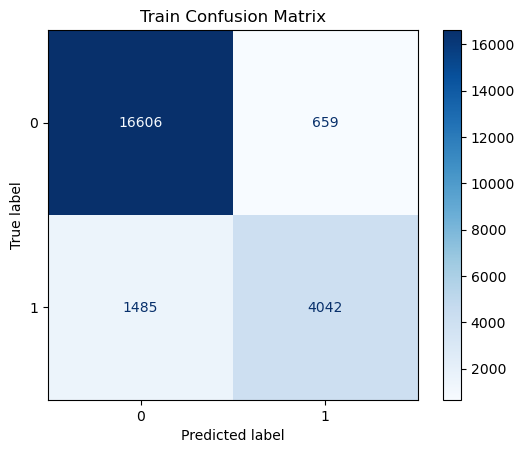

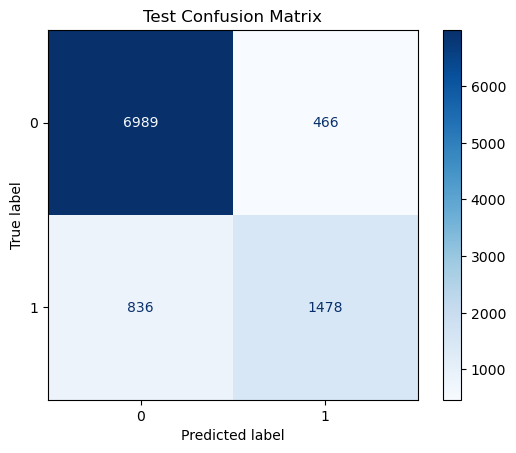

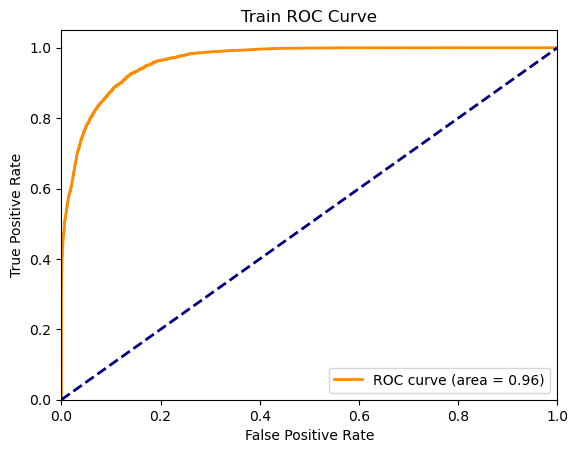

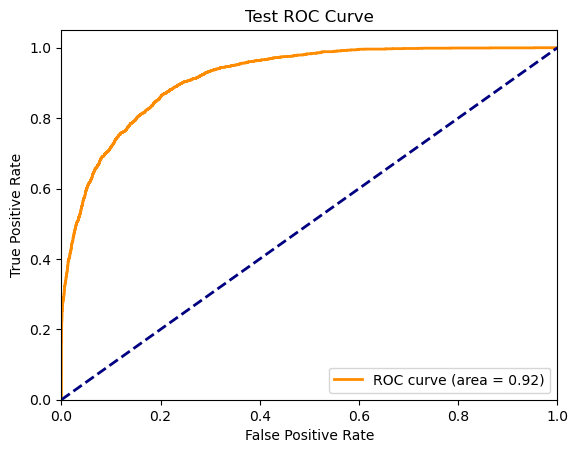

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     17265
           1       0.86      0.73      0.79      5527

    accuracy                           0.91     22792
   macro avg       0.89      0.85      0.86     22792
weighted avg       0.90      0.91      0.90     22792

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      7455
           1       0.76      0.64      0.69      2314

    accuracy                           0.87      9769
   macro avg       0.83      0.79      0.80      9769
weighted avg       0.86      0.87      0.86      9769

Training time: 0.21 seconds
=== MLP Evaluation ===
Train Accuracy: 0.8841
Test Accuracy: 0.8475


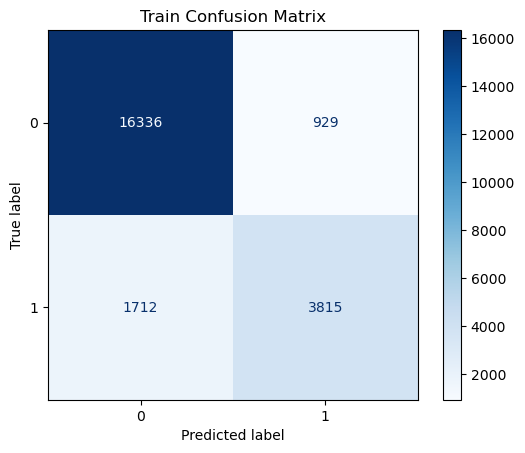

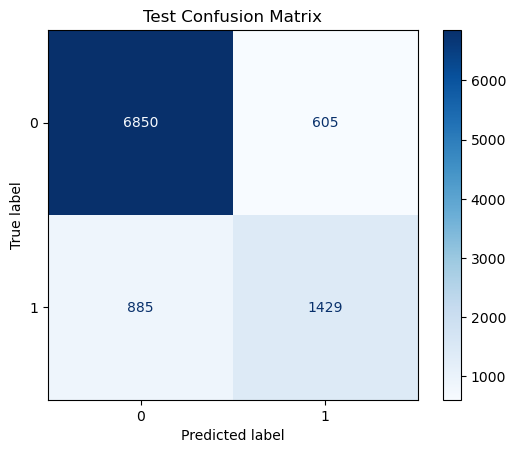

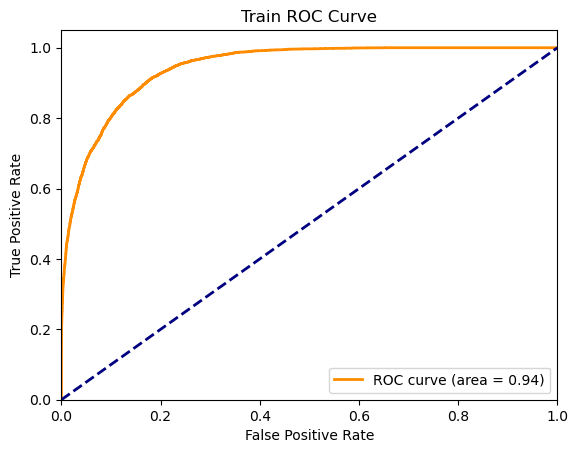

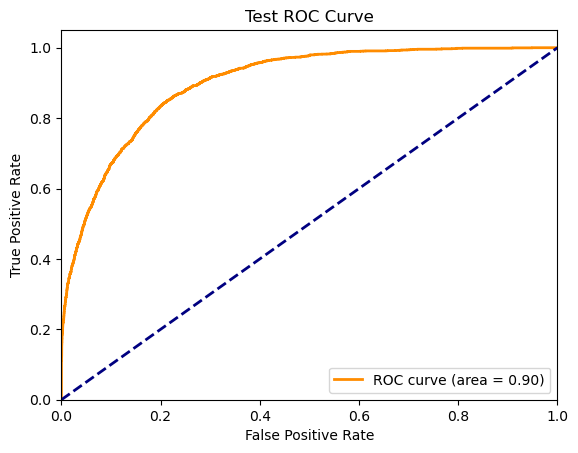

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     17265
           1       0.80      0.69      0.74      5527

    accuracy                           0.88     22792
   macro avg       0.85      0.82      0.83     22792
weighted avg       0.88      0.88      0.88     22792

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      7455
           1       0.70      0.62      0.66      2314

    accuracy                           0.85      9769
   macro avg       0.79      0.77      0.78      9769
weighted avg       0.84      0.85      0.84      9769

Training time: 10.98 seconds
=== CatBoost Evaluation ===
Train Accuracy: 0.9882
Test Accuracy: 0.8624


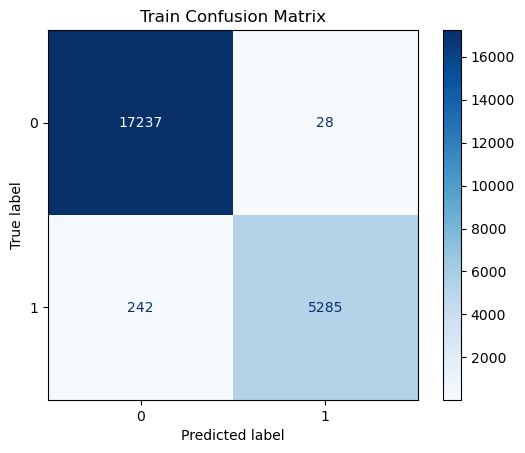

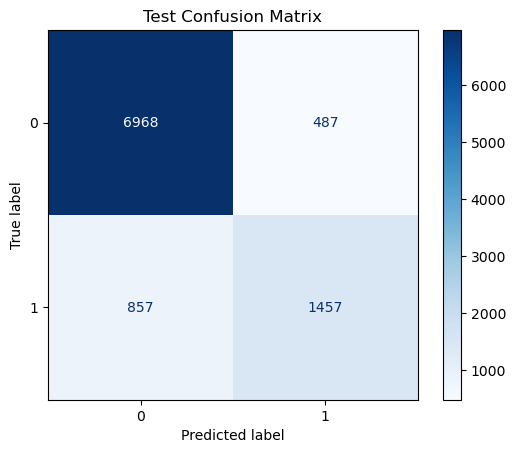

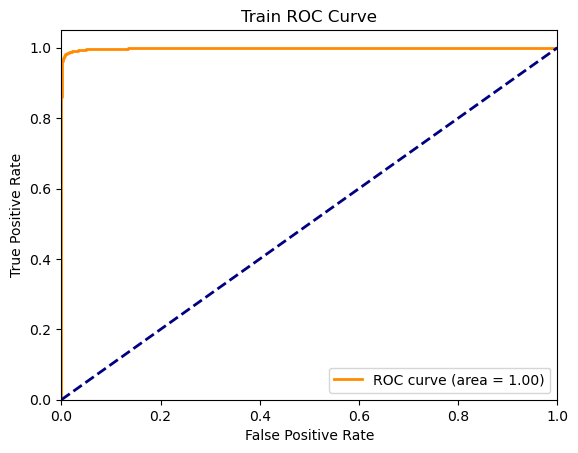

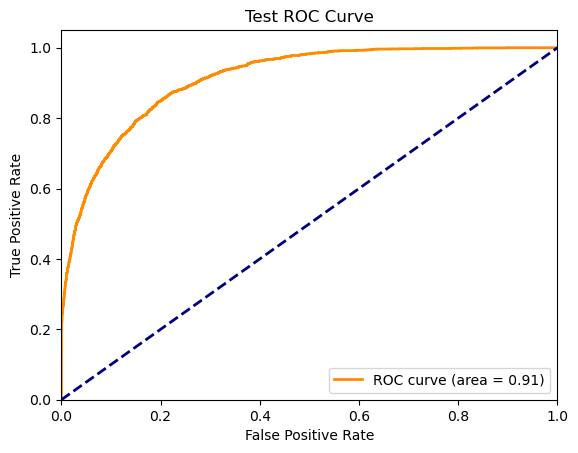

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     17265
           1       0.99      0.96      0.98      5527

    accuracy                           0.99     22792
   macro avg       0.99      0.98      0.98     22792
weighted avg       0.99      0.99      0.99     22792

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7455
           1       0.75      0.63      0.68      2314

    accuracy                           0.86      9769
   macro avg       0.82      0.78      0.80      9769
weighted avg       0.86      0.86      0.86      9769

Training time: 4.62 seconds


In [10]:
'''
Objective: Train supervised learning algorithms and assess its performance.
Train a simple machine learning model and assess its performance.
Instructions
    1. Choose a classification target (e.g. classification of a value).
    2. Choose at least two simple model classes (e.g., decision tree, logistic regression).
    3. Split the dataset into training (e.g., 70%) and testing (e.g., 30%) sets.
    4. Train the model classes on the training set.
    5. Test the trained model on the the training set, testing set and the entire set.
'''


class Classifier:
    def __init__(self, model, random_state=42):
        self.dataloader = DataLoader()
        self.model = model
        self.random_state = random_state
        self.results = None

    def set_model(self, model):
        """
        Set model
        """
        self.model = model

    def load_and_preprocess_data(self, file_path, test_size=0.3):
        """
        Load and preprocess data
        """
        raw_data = self.dataloader.load_data(file_path)
        self.x, self.y = self.dataloader.preprocess_data(raw_data)
        self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(
            self.x, self.y, test_size=test_size, random_state=self.random_state
        )

    def train(self):
        """
        Train the SVM model
        """
        self.model.fit(self.train_x, self.train_y)

    def predict(self, x):
        """
        Predict
        """
        return self.model.predict(x)

    def evaluate(self):
        """
        Evaluate model performance
        """
        self.train_y_pred = self.model.predict(self.train_x)
        self.test_y_pred = self.model.predict(self.test_x)
        self.total_y_pred = self.model.predict(self.x)

        print("accuracy on train set: ", accuracy_score(
            self.train_y, self.train_y_pred))
        print("accuracy on test set: ", accuracy_score(
            self.test_y, self.test_y_pred))
        print("accuracy on total set: ",
              accuracy_score(self.y, self.total_y_pred))

    def random_search(self, param_grid, n_iter=5):
        """
        Random search for hyperparameters
        """
        # Define random search
        search = RandomizedSearchCV(
            self.model,
            param_distributions=param_grid,
            n_iter=n_iter,
            cv=2,
            random_state=self.random_state,
            n_jobs=-1,
            verbose=2,
        )
        search.fit(self.train_x, self.train_y)
        print("Best parameters found: ", search.best_params_)
        return search.best_estimator_, search.best_params_


# 3. XGBoost (binary classification)
param_grid_xgb = {
    # learning rate
    'eta': [0.01, 0.05, 0.1, 0.2],
    # max tree depth
    'max_depth': [3, 5, 7, 10],
    # subsample ratio
    'subsample': [0.6, 0.8, 1.0],
    # column subsample ratio
    'colsample_bytree': [0.6, 0.8, 1.0],
    # minimum loss reduction for further partition
    'gamma': [0, 0.1, 0.2, 0.5],
    # L1 regularization term
    'alpha': [0, 0.1, 1, 10],
    # L2 regularization term
    'lambda': [1, 2, 5, 10]
}

# Define models and titles to test
models = [
    # ("Logistic Regression", LogisticRegression(
    #     max_iter=1000, random_state=42)),
    # ("Decision Tree", DecisionTreeClassifier(
    #     max_depth=6, random_state=42)),
    # ("SVM", SVC(kernel='linear', random_state=42)),
    # ("Random Forest", RandomForestClassifier(
    #     n_estimators=100, max_depth=6, random_state=42)),
    ("XGBoost", XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        eta=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )),
    # ("KNN", KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2)),
    ("MLP", MLPClassifier(
        hidden_layer_sizes=(100,),  # Hidden layer size (100 neurons)
        activation='relu',         # Activation function (default relu)
        solver='adam',             # Optimizer (default adam)
        max_iter=400,              # Max iterations
        random_state=42
    )),
    # ("LGBM", LGBMClassifier(
    #     objective='binary',
    #     metric='binary_logloss',
    #     learning_rate=0.1,
    #     max_depth=6,
    #     num_leaves=31,
    #     min_child_samples=10,
    #     min_split_gain=0.01,
    #     max_bin=128,
    #     class_weight='balanced',
    #     random_state=42
    # )),
    ("CatBoost", CatBoostClassifier(
        iterations=1000,
        depth=6,

        learning_rate=0.1,
        loss_function='Logloss',
        random_seed=42,
        verbose=0
    ))
]


def main_train_test():
    evaluation = Evaluation()
    # Initialize Classifier with the first model
    classifier = Classifier(model=models[0][1], random_state=42)
    classifier.load_and_preprocess_data('raw/adult.data')

    # Iterate through the model list, train and evaluate each
    for title, model in models:
        print(f"=== {title} Evaluation ===")
        classifier.set_model(model)
        start_time = time.time()
        classifier.train()
        end_time = time.time()
        evaluation.evaluate_model(
            classifier.model,
            classifier.train_x,
            classifier.train_y,
            classifier.test_x,
            classifier.test_y
        )
        print(f"Training time: {end_time - start_time:.2f} seconds")

        # print("=== Cross Validation ===")
        # start_time = time.time()
        # try:
        #     # Ensure model is compatible with cross_val_score
        #     if hasattr(model, "fit") and hasattr(model, "predict"):
        #         scores = cross_val_score(
        #             classifier.model, classifier.x, classifier.y, cv=5
        #         )
        #         print(f"Cross-validation scores: {scores}")
        #         print(f"Mean cross-validation score: {scores.mean():.4f}")
        #     else:
        #         print(f"{title} is not compatible with cross_val_score.")
        # except Exception as e:
        #     print(f"Error during cross-validation for {title}: {e}")
        # end_time = time.time()
        # print(f"Cross-validation time: {end_time - start_time:.2f} seconds")


def main_random_search():
    # Use SVM to create initial Classifier, then change with set_model
    classifier = Classifier(model=models[0][1], random_state=42)
    classifier.load_and_preprocess_data('raw/adult.data')

    # XGBoost
    classifier.set_model(XGBClassifier(random_state=42))
    best_model, best_param = classifier.random_search(param_grid_xgb, n_iter=3)
    classifier.set_model(best_model)
    classifier.train()
    print("=== Best XGBoost Model Evaluation ===")
    print("Best parameters: ", best_param)
    classifier.evaluate()


if __name__ == "__main__":
    # main_train_test()
    main_train_test()